In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DATASET
!unzip HOVA10.zip

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install keras==3.3.3

In [ ]:
import os, cv2
import tensorflow as tf
# from model.rep_efficientnet_v2 import EfficientNetV2B3
import keras
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from model.losses import categorical_focal_crossentropy
from keras.utils import image_dataset_from_directory
import tensorflow as tf
import glob
import keras
import numpy as np
from keras import Sequential, Model
from keras.layers import Input, Layer, AveragePooling2D, Conv2D, BatchNormalization, Dropout, Dense, Flatten, ReLU, ZeroPadding2D
from tqdm import tqdm


def unfreeze_model(model, unfree=False, precent=10):
    length = len(model.layers)
    top_layer = int(length * (precent/100))
    print("length : ", length, "top_layer: ", top_layer, "int(precent/100): ", precent/100)
    if unfree:
        # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
        top_layer *= -1
        for layer in model.layers[top_layer:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
                print("Layer >> ", layer)
    return model


def load_images(dir_images, gray=False, dsize=(224, 224)):
    tasks = ('train', 'val')
    data, labels = [], []
    for _, task in tqdm(enumerate(tasks)):
        cates = os.listdir(os.path.join(dir_images, task))
        for cate in cates:
            files = os.listdir(os.path.join(dir_images, task, cate))
            for img_file in files:
                labels.append(cate)
                image = cv2.imread(os.path.join(dir_images, task, cate, img_file))
                image = cv2.resize(image, dsize)
                if gray:
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    data.append(gray_image)
                else:
                    data.append(image)
    return data, labels


def scale_up_lora(inputs, units, lora_rank, lora_num_layer, activation=None, name='lora'):
    lora_denses = []
    for i in range(lora_num_layer):
        lora_denses.append(keras.layers.Dense(units, activation=activation,
                                              lora_rank=lora_rank, name=f'{name}_dense_{i}')(inputs))
    lora_denses.append(inputs)
    x_nlora = keras.layers.Add(name=f'{name}_add')(lora_denses)
    # x_activation = keras.activations.relu(x_nlora)
    x_bn = keras.layers.BatchNormalization()(x_nlora)
    return x_bn


def build_model(size):
    inputs = keras.Input(shape=(*size, 1))
    # x_rescaling = keras.layers.Rescaling(scale=1./127.5, offset=-1)(inputs)
    x_base_model = base_model(inputs, training=False)
    x_flatten = keras.layers.GlobalAveragePooling2D()(x_base_model)
    x_dropout1 = keras.layers.Dropout(0.3)(x_flatten)
    # x_activation = keras.activations.relu(x_dropout1)
    x_nlora = scale_up_lora(x_dropout1, units=x_dropout1.shape[1], lora_rank=5, lora_num_layer=3, activation='relu')

    x_dropout2 = keras.layers.Dropout(0.3)(x_nlora)
    outputs = keras.layers.Dense(10, activation='softmax')(x_dropout2)
    model = keras.Model(inputs, outputs)
    # init_weights = model.get_weights()
    return model


In [ ]:
import os
import shutil


def save_training(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    length = len(glob.glob(save_dir + "/train*"))
    save_dir = os.path.join(save_dir, f'train{length+1}')
    os.makedirs(save_dir, exist_ok=True)
    print(">>>>>>>>>> ", save_dir)
    return save_dir


def get_cacll_back(save_dir):
    checkpoint_filepath = os.path.join(save_dir, 'best.weights.h5')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True)

    model_stop = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                            verbose=1,
                                            patience=10,
                                            mode='max',
                                            restore_best_weights=False),
    return [
        model_stop,
        model_checkpoint_callback
    ]

In [ ]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# base_model = unfreeze_model(base_model, unfree=True, precent=30) # unfree 30% top layer
# base_model.summary(show_trainable=True)

In [ ]:
# temp model
model = build_model(size=(224, 224))
init_weights = model.get_weights()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 7, 7, 1792)     │     17,673,823 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1792)           │              0 │ efficientnetb4[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1792)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_0 (Dense)      │ (None, 1792)           │      3,230,976 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_1 (Dense)      │ (None, 1792)           │      3,230,976 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_2 (Dense)      │ (None, 1792)           │      3,230,976 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_add (Add)            │ (None, 1792)           │              0 │ lora_dense_0[0][0],    │
│                           │                        │                │ lora_dense_1[0][0],    │
│                           │                        │                │ lora_dense_2[0][0],    │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1792)           │          7,168 │ lora_add[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1792)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10)             │         17,930 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,391,849 (104.49 MB)

 Trainable params: 80,650 (315.04 KB)

 Non-trainable params: 27,311,199 (104.18 MB)

# Training with Train/Val

>>>>>>>>>>  /content/drive/MyDrive/DATASET/logs/hova10/train4


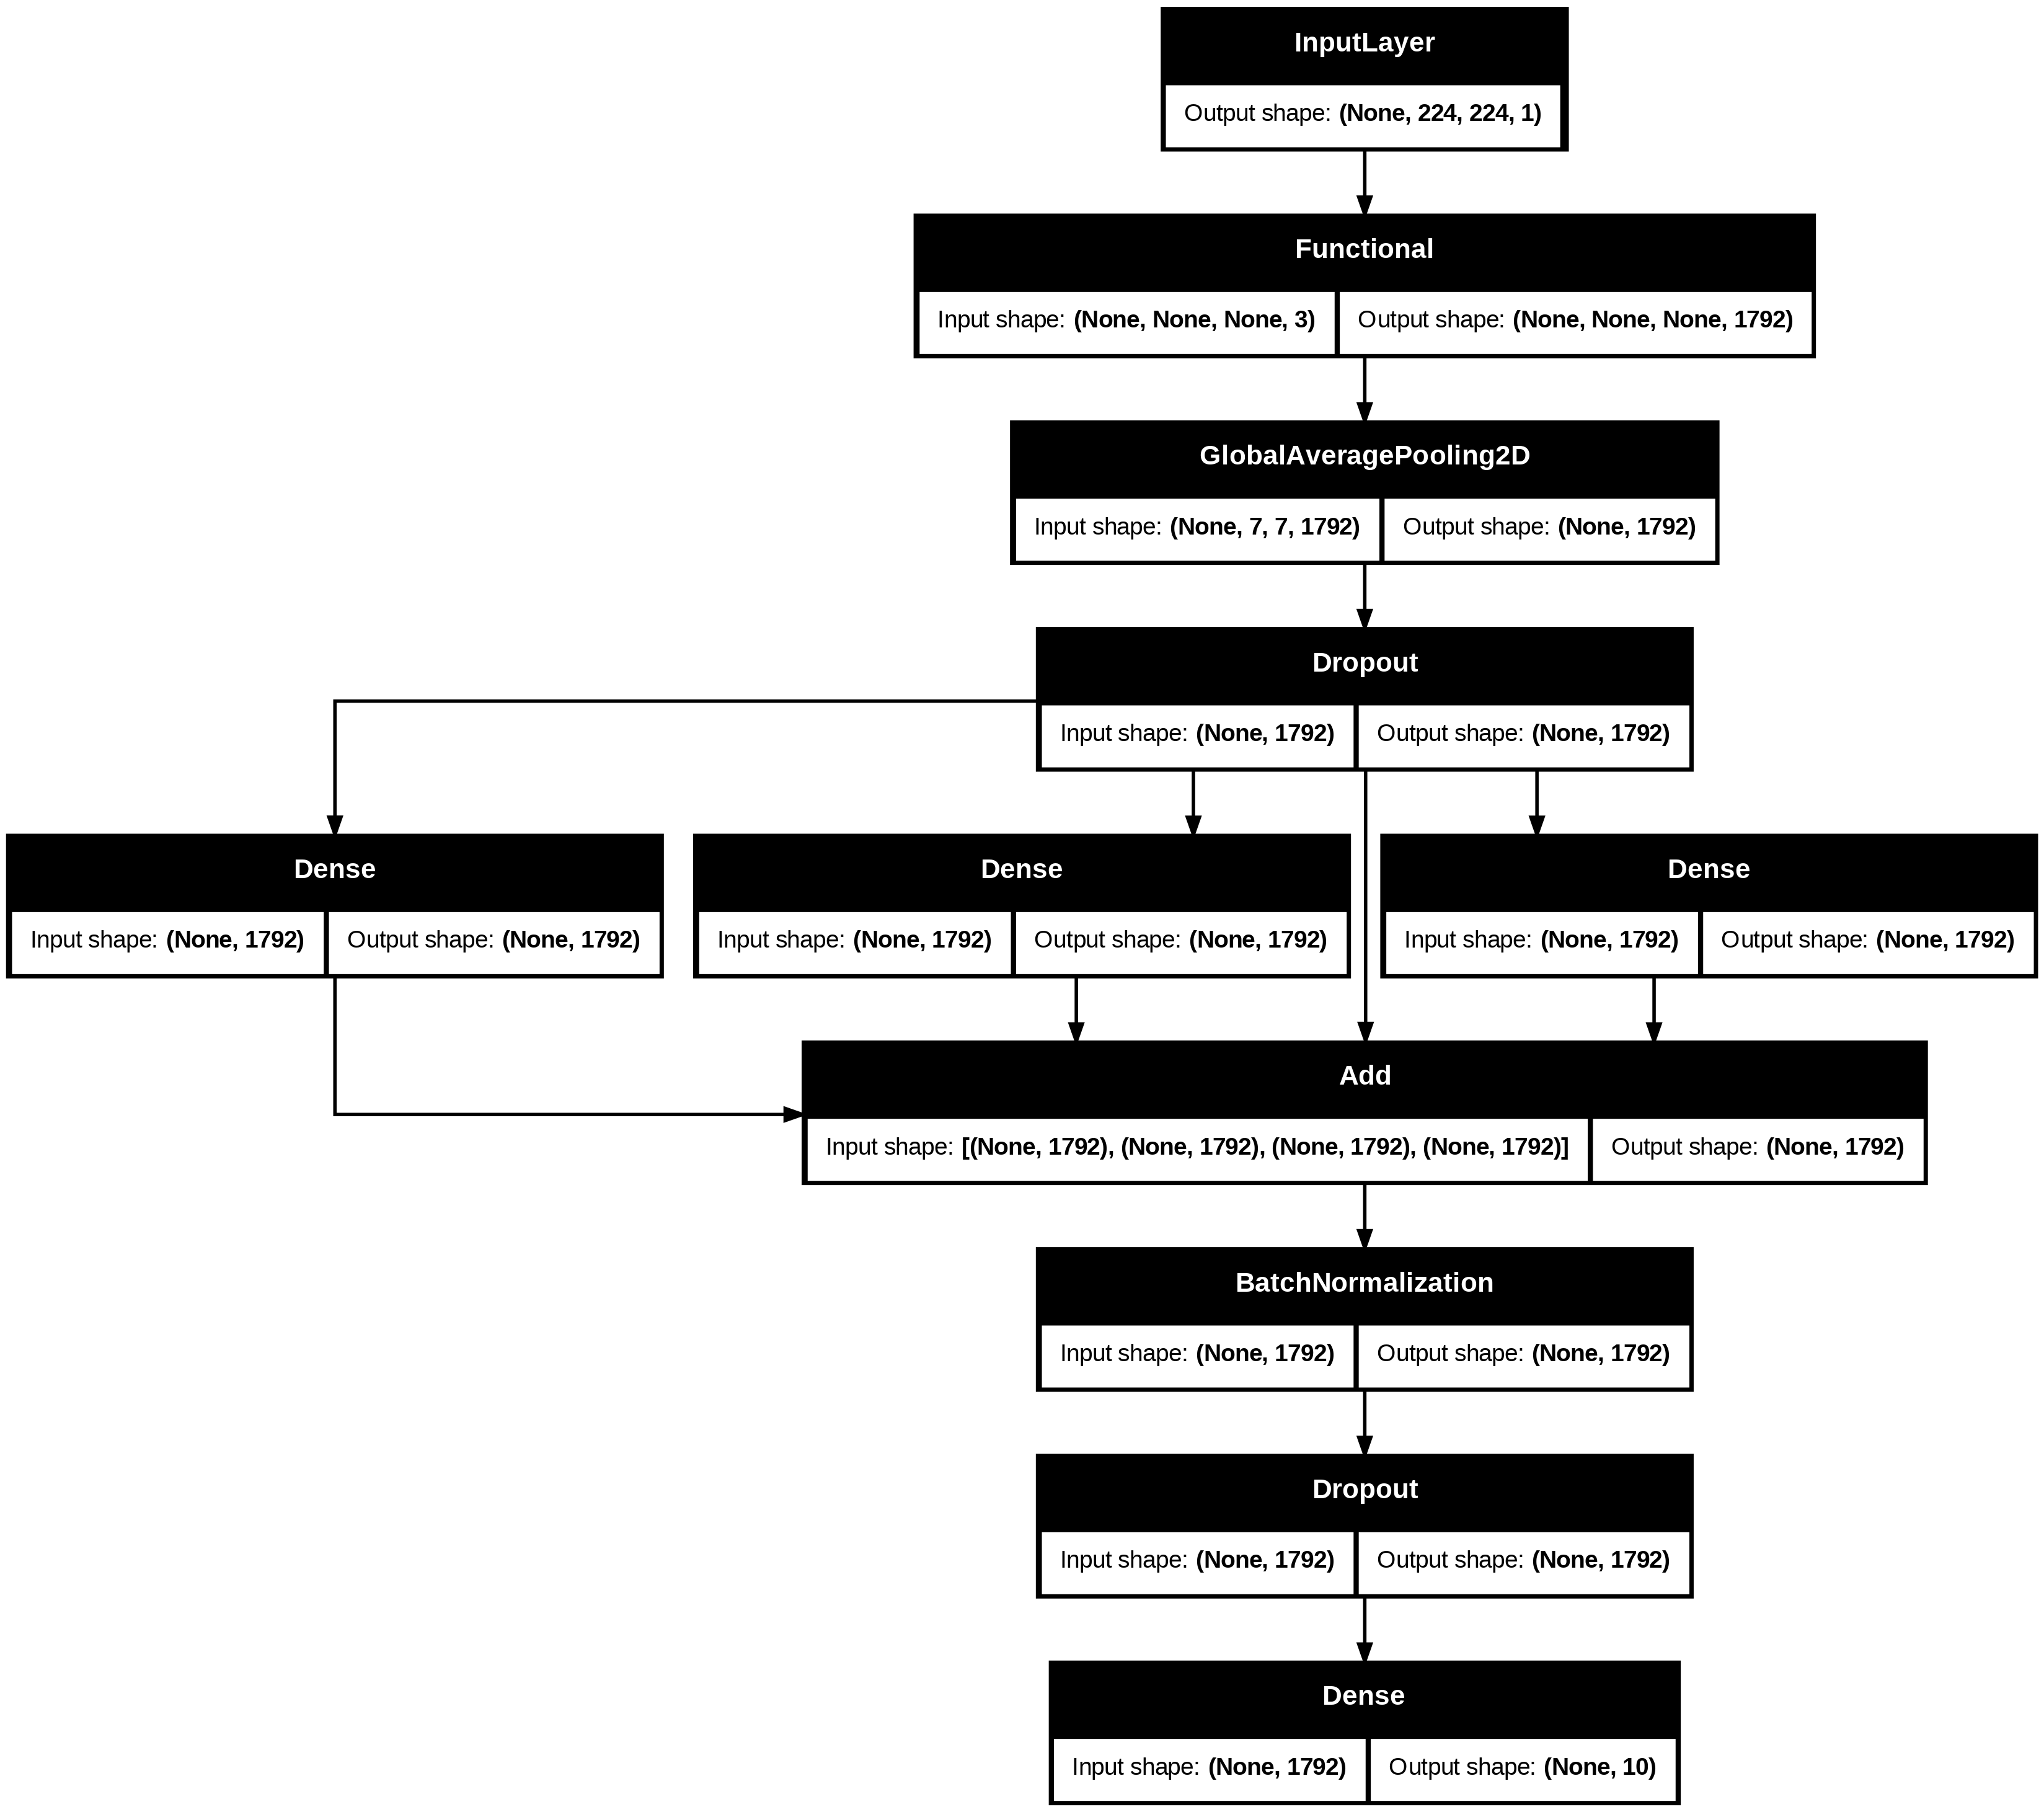

In [ ]:
save_path = "/content/drive/MyDrive/DATASET/logs/hova10"
save_history = save_training(save_path)
keras.utils.plot_model(model, to_file=os.path.join(save_history, 'model.png'), show_shapes=True)

In [ ]:
focal = keras.losses.categorical_focal_crossentropy
METRICS = [
    # tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='Top1'),
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
]

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=[focal], metrics = METRICS)
my_callbacks = get_cacll_back(save_dir=save_path)

In [ ]:
train_dir = "/content/drive/MyDrive/DATASET/HOVA10/train"
test_dir = "/content/drive/MyDrive/DATASET/HOVA10/val/"
size = (64, 64)
batch_size = 32
train = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)
val = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)

In [ ]:
model.set_weights(init_weights)
epoch = 100
history = model.fit(
        x = train,
        epochs = epoch,
        validation_data = val,
        batch_size=batch_size,
        shuffle=True,
        callbacks=my_callbacks,
        # steps_per_epoch = len(train.file_paths) // batch_size,
        # validation_steps=len(val.file_paths) // batch_size,
        # sample_weight=train.sample_weight
        # workers=5
        #  class_weight = class_weight
)

In [ ]:
model.save_weights(os.path.join(save_path, 'last.weights.h5'))
print("save to >>>>>>>>>> ", os.path.join(save_path, 'last.weights.h5'))

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)
hist_csv_file = os.path.join(save_path, 'history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_train = pd.read_csv(hist_csv_file)
print(df_train.columns)

loss = df_train['loss'].values
val_loss = df_train['val_loss'].values

acc = df_train['categorical_accuracy'].values
val_acc = df_train['val_categorical_accuracy'].values

logs_train = [
    [[loss, val_loss, "plot loss", ["loss", "val_loss"]], [acc, val_acc, "plot categorical_accuracy", ["acc", "val_acc"]]],
]

fig, axs = plt.subplots(1, 2, figsize=(16, 7), squeeze=False)
eps = [i for i in range(0, len(loss))]
for row, sub_logs_train in enumerate(logs_train):
    for col, (train, val, title, legend) in enumerate(sub_logs_train):
        # print(legend)
        axs[row][col].plot(eps, train)
        axs[row][col].plot(eps, val)
        axs[row][col].set_title(title)
        axs[row][col].legend(legend)
        axs[row][col].set_xlabel("epochs")
        axs[row][col].set_ylabel("scores")

fig.show()

In [ ]:
model.load_weights(os.path.join(save_path, "best.weights.h5"))
val_metrics = model.evaluate(val, batch_size=batch_size)
print("Val Loss: ", val_metrics[0])
print("Val Acc: ", val_metrics[1])

# Training KFOLD

In [ ]:
# load full dataset

images, labels = load_images(dir_images="/content/drive/MyDrive/DATASET/HOVA10", gray=True, dsize=(224, 224))
images = np.array(images)
labels = np.array(labels)
images.shape, labels.shape

2it [01:02, 31.41s/it]


((2190, 224, 224), (2190,))

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# setup KFOLD
lb = preprocessing.LabelBinarizer()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10000)
skf.get_n_splits(images, labels)
print(skf)

# setup model
model = build_model(size=images.shape[1:])
init_weights = model.get_weights()

StratifiedKFold(n_splits=5, random_state=10000, shuffle=True)


In [ ]:
save_kfold = "/content/drive/MyDrive/DATASET/logs/hova10"
save_kfold_path = save_training(save_kfold)
save_kfold_path

>>>>>>>>>>  /content/drive/MyDrive/DATASET/logs/hova10/train6


'/content/drive/MyDrive/DATASET/logs/hova10/train6'

In [ ]:

batch_size = 32
epoch = 100
for i, (train_index, test_index) in enumerate(skf.split(images, labels)):
    os.makedirs(os.path.join(save_kfold_path, f"KFold{i}"), exist_ok=True)

    labels_one_hot_train = lb.fit_transform(labels[train_index])
    labels_one_hot_val = lb.fit_transform(labels[test_index])
    print(f"Fold {i}:")
    print("train : ", images[train_index].shape, labels_one_hot_train.shape)
    print("val : ", images[test_index].shape, labels_one_hot_val.shape)

    # training
    focal = keras.losses.categorical_focal_crossentropy
    METRICS = [
        # tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='Top1'),
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    ]
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=[focal], metrics = METRICS)
    my_callbacks = get_cacll_back(os.path.join(save_kfold_path, f"KFold{i}"))


    model.set_weights(init_weights)
    history = model.fit(images[train_index], labels_one_hot_train,
            epochs = epoch,
            validation_data = (images[test_index], labels_one_hot_val),
            batch_size=batch_size,
            shuffle=True,
            callbacks=my_callbacks,
            # steps_per_epoch = len(train.file_paths) // batch_size,
            # validation_steps=len(val.file_paths) // batch_size,
            # sample_weight=train.sample_weight
            # workers=5
            #  class_weight = class_weight
    )

    model.save_weights(os.path.join(save_kfold_path, f"KFold{i}", 'last.weights.h5'))
    print("save to >>>>>>>>>> ", os.path.join(save_kfold_path, f"KFold{i}", 'last.weights.h5'))

    import pandas as pd

    # convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = os.path.join(save_kfold_path, f"KFold{i}", 'history.csv')
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f, index=False)

    model.load_weights(os.path.join(save_kfold_path, f"KFold{i}", "best.weights.h5"))
    val_metrics = model.evaluate(images[test_index], labels_one_hot_val, batch_size=batch_size)
    print("Val Loss: ", val_metrics[0])
    print("Val Acc: ", val_metrics[1])
